## Librairies + importation

In [47]:
import sys
sys.path.append('C:\\Users\\ESP Consulting\\AppData\\Local\\mambaforge\\lib\\site-packages')

from pathlib import Path
# from scipy import signal, fftpack, fft, integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
import pandas as pd
import re
import os
import tkinter as tk
from tkinter import filedialog
from scipy.interpolate import interp1d

# Data_Path = Path(
#     "C:\\Users\\l.boisson\\Documents\\LPG\\Manips"
# )

sns.set_theme()
sns.set_style("white")

## Recherche du dossier d'input

In [48]:
# crée une instance GUI
root = tk.Tk()
root.withdraw()  # Hide the main window

# Ask user to select the data folder using a file explorer dialog
# Check if data_folder_path is already loaded in Jupyter variables
try:
    data_folder_path
except NameError:
    data_folder_path = None

if data_folder_path is None:
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Open file explorer dialog to select the data folder
    data_folder_path = filedialog.askdirectory(title="Select Data Folder")

    if not data_folder_path:
        print("No folder selected. Exiting.")
        exit()
Data_Path = Path(data_folder_path)

path_export = Data_Path.as_posix() + '/Exports/'
if not os.path.exists(path_export):
    os.makedirs(path_export)

## Définition des fonctions

In [49]:
def extract_file_info(file_path):
    """Extrait les noms des différentes identifiant des fichiers

    Args:
        filename (str): nom du fichier

    Returns:
        dict: dictionnaire des strings de chaque identifiant 
        session, participant, condition et raquette
    """
    match_participant = re.search(r"(\d{3})", file_path)
    participant = match_participant.group() if match_participant else None
    
    match_condition = re.search(r"(CH|H|CTRL)", file_path)
    condition = match_condition.group() if match_condition else None
    
    match_contraction = re.search(r"(CON60|EXC|ISO)", file_path)
    contraction = match_contraction.group() if match_contraction else None
    
    match_essai = re.search(r"_(\d{1})_", file_path)
    essai = match_essai.group(1) if match_essai else None
    
    if contraction == 'EXC':
        match_essai = re.search(r"(?<=_)\w{1,2}(?=.cxp)", file_path)
        essai = match_essai.group() if match_essai else None
        mesure = 0
    
    else:
        match_mesure = re.search(r"(?<=_)\w{2}(?=.cxp)", file_path)
        mesure = match_mesure.group() if match_mesure else None
        
    return {
        "participant": participant,
        "condition": condition,
        "contraction": contraction,
        "essai": essai,
        "mesure": mesure
    }
    
def apply_calcul_repetitions(group):
    """Détermine les seuils de force et le nombre minimal de répétitions consécutives en fonction des critères spécifiques de certains groupes

    Args:
        group (pd.DataFrame): groupe de données avec les colonnes 'participant', 'contraction', 'condition' et 'essai'

    Returns:
        dict: résultats du calcul des répétitions selon les seuils déterminés
    """
    if (group['participant'].iloc[0] == '007') & (group['contraction'].iloc[0] == 'EXC'):
        force_threshold = 50
        min_consecutive = 30

    elif (group['participant'].iloc[0] == '007') & (group['contraction'].iloc[0] == 'EXC') & (group['condition'].iloc[0] == 'CTRL') & (group['essai'].iloc[0] == '3'):
        force_threshold = 40
        min_consecutive = 4

    elif (group['contraction'].iloc[0] == 'EXC'):
        force_threshold = 40
        min_consecutive = 15

    else:
        force_threshold = 25
        min_consecutive = 4

    return calcul_repetitions(group, force_threshold, min_consecutive)

def calcul_repetitions(df, force_threshold, min_consecutive):
    """Calcule les répétitions de mouvements basées sur un seuil de force et un nombre minimal de répétitions consécutives

    Args:
        df (pd.DataFrame): DataFrame contenant les données de force
        force_threshold (float): Seuil de force pour distinguer les mouvements
        min_consecutive (int): Nombre minimal de points consécutifs au-dessus du seuil pour compter une répétition

    Returns:
        pd.DataFrame: DataFrame avec les colonnes mises à jour pour les mouvements et les répétitions
    """
    df = df.copy()

    df.loc[df.Force < force_threshold, 'mouvement'] = 'Flexion'
    df.loc[df.Force >= force_threshold, 'mouvement'] = 'Extension'

    df['repetition'] = 0

    threshold_down = False
    repetition = 0

    i = 0
    while i < len(df):
        
        if df.loc[df.index[i], 'Force'] >= force_threshold and not threshold_down:
            if i + min_consecutive <= len(df) and all(df.loc[df.index[i:i+min_consecutive], 'Force'] >= force_threshold):
                repetition += 1
                threshold_down = True
                i += min_consecutive - 1
            else:
                threshold_down = False
        elif df.loc[df.index[i], 'Force'] < force_threshold:
            threshold_down = False
        df.loc[df.index[i], 'repetition'] = repetition
        i += 1

    return df

def reset_time(df):
    """Réinitialise la colonne 'Time' pour qu'elle commence à zéro pour chaque répétition

    Args:
        df (pd.DataFrame): DataFrame contenant la colonne 'Time'

    Returns:
        pd.DataFrame: DataFrame avec la colonne 'Time' réinitialisée à partir de zéro
    """
    print(df.name)
    df.Time -= df.Time.values[0]
    return df

def resample_phase(df):
    """Effectue un rééchantillonnage des données de chaque phase en utilisant l'interpolation

    Args:
        df (pd.DataFrame): DataFrame contenant les données à rééchantillonner

    Returns:
        pd.DataFrame: DataFrame rééchantillonnée avec 100 points uniformément répartis pour chaque répétition
    """
    # Calculate the step duration
    try:
        # Calculate the resampling frequency
        resampling = np.linspace(
            df["Time"].iloc[0], df["Time"].iloc[-1], num=100, endpoint = True
        )

        # Resample the data for this step using interpolation
        interp_data = df.drop("Time", axis=1).apply(
            lambda col: interp1d(df["Time"], col)(resampling)
        ).rename_axis('Cycle_%')

    except IndexError:
        print(f"Error encountered in {df.index.unique()}. Skipping this group...")
        return pd.DataFrame()
    
    return interp_data

## Extraction des données

In [50]:
df_column = pd.DataFrame()

for filename in Data_Path.glob("Manips_test/*.cxp"):
    print(filename)
    file_path = filename.as_posix()
    file_info = extract_file_info(filename.name)
    
    if file_info is not None:
        contraction_type = file_info["contraction"]
        if contraction_type in ["ISO"]:
            skiprows = 151
        else:
            skiprows = 210
        
        data = pd.read_table(
            file_path,
            on_bad_lines='skip',
            encoding='latin-1',
            skiprows=skiprows,
            names=["Force", "Vitesse", "Angle"],
            header=0
        )
        
        data = data.assign(**file_info)
        
        df_column = pd.concat([df_column, data])

df_column['Frame'] = df_column.groupby(["participant", "condition", "contraction", "essai", "mesure"]).cumcount() + 1

df_column['Time'] = df_column['Frame'] / 256
df_column['Vitesse'] = df_column['Vitesse']
df_column['Angle'] = df_column['Angle']

df_column = df_column.reset_index(drop=True)

df_column = df_column[~((df_column['participant'] == '003') & 
          (df_column['contraction'] == 'CON60') & 
          (df_column['condition'] == 'CH') & 
          (df_column['mesure'] == '02') & 
          (df_column['Time'] >= 17))]

df_column

C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\001_CH_EXC_1.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\001_CH_EXC_10.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\001_CH_EXC_2.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\001_CH_EXC_3.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\001_CH_EXC_4.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\001_CH_EXC_5.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\001_CH_EXC_6.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\001_CH_EXC_7.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\001_CH_EXC_8.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\001_CH_EXC_9.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\001_CTRL_EXC_1.cxp
C:\Users\ESP Consulting\Docum

Force  Vitesse   Angle participant condition contraction essai  \
0       -15.281   15.622 -81.809         001        CH         EXC     1   
1       -15.321   15.231 -81.750         001        CH         EXC     1   
2       -15.117   15.231 -81.690         001        CH         EXC     1   
3       -14.629   14.450 -81.634         001        CH         EXC     1   
4       -15.157   14.450 -81.577         001        CH         EXC     1   
...         ...      ...     ...         ...       ...         ...   ...   
1931853  -2.902    0.000 -90.137         008         H         EXC     9   
1931854  -3.390    0.391 -90.136         008         H         EXC     9   
1931855  -2.658    0.000 -90.136         008         H         EXC     9   
1931856  -3.390   -0.391 -90.137         008         H         EXC     9   
1931857   0.000    0.000   0.000         008         H         EXC     9   

         mesure  Frame       Time  
0             0      1   0.003906  
1             0      2   0.007812  
2             0      3   0.011719  
3             0      4   0.015625  
4             0      5   0.019531  
...         ...    ...        ...  
1931853       0   6313  24.660156  
1931854       0   6314  24.664062  
1931855       0   6315  24.667969  
1931856       0   6316  24.671875  
1931857       0   6317  24.675781  

[1931858 rows x 10 columns]

## Détection des répétitions

In [51]:
df_force_phase = df_column.groupby(['participant', 'condition', 'contraction', 'essai', 'mesure']).apply(apply_calcul_repetitions).reset_index(drop=True)

df_force_phase

C:\Users\ESP Consulting\AppData\Local\Temp\ipykernel_2944\4188332514.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_force_phase = df_column.groupby(['participant', 'condition', 'contraction', 'essai', 'mesure']).apply(apply_calcul_repetitions).reset_index(drop=True)


Force  Vitesse   Angle participant condition contraction essai  \
0       -15.281   15.622 -81.809         001        CH         EXC     1   
1       -15.321   15.231 -81.750         001        CH         EXC     1   
2       -15.117   15.231 -81.690         001        CH         EXC     1   
3       -14.629   14.450 -81.634         001        CH         EXC     1   
4       -15.157   14.450 -81.577         001        CH         EXC     1   
...         ...      ...     ...         ...       ...         ...   ...   
1931853  -2.902    0.000 -90.137         008         H         EXC     9   
1931854  -3.390    0.391 -90.136         008         H         EXC     9   
1931855  -2.658    0.000 -90.136         008         H         EXC     9   
1931856  -3.390   -0.391 -90.137         008         H         EXC     9   
1931857   0.000    0.000   0.000         008         H         EXC     9   

         mesure  Frame       Time mouvement  repetition  
0             0      1   0.003906   Flexion           0  
1             0      2   0.007812   Flexion           0  
2             0      3   0.011719   Flexion           0  
3             0      4   0.015625   Flexion           0  
4             0      5   0.019531   Flexion           0  
...         ...    ...        ...       ...         ...  
1931853       0   6313  24.660156   Flexion           6  
1931854       0   6314  24.664062   Flexion           6  
1931855       0   6315  24.667969   Flexion           6  
1931856       0   6316  24.671875   Flexion           6  
1931857       0   6317  24.675781   Flexion           6  

[1931858 rows x 12 columns]

## Suppression des mauvaises répétitions détectées

In [54]:
filters = [
    {'participant': '007', 'contraction': 'EXC', 'condition': 'H', 'essai': '3', 'repetition': [1, 2, 3]},
    {'participant': '007', 'contraction': 'EXC', 'condition': 'H', 'essai': '4', 'repetition': [6]},
    {'participant': '005', 'contraction': 'EXC', 'condition': 'CH', 'essai': '3', 'repetition': [1, 2]},
    {'participant': '003', 'contraction': 'CON60', 'condition': 'CH', 'mesure': '01', 'repetition': [3]},
    {'participant': '003', 'contraction': 'CON60', 'condition': 'CH', 'mesure': '21', 'repetition': [4]},
    {'participant': '003', 'contraction': 'CON60', 'condition': 'CTRL', 'mesure': '21', 'repetition': [4]},
    {'participant': '002', 'contraction': 'CON60', 'condition': 'CTRL', 'mesure': '21', 'repetition': [4]},
    {'participant': '002', 'contraction': 'CON60', 'condition': 'CH', 'mesure': '01', 'repetition': [5]},
    {'participant': '001', 'contraction': 'CON60', 'condition': 'H', 'mesure': '01', 'repetition': [3]},
    {'participant': '001', 'contraction': 'CON60', 'condition': 'H', 'mesure': '21', 'repetition': [3]},
    {'participant': '004', 'contraction': 'CON60', 'condition': 'CTRL', 'mesure': '02', 'repetition': [3]},
    {'participant': '005', 'contraction': 'CON60', 'condition': 'CTRL', 'mesure': '01', 'repetition': [1]},
    {'participant': '005', 'contraction': 'CON60', 'condition': 'CH', 'mesure': '11', 'repetition': [6, 2]},
    {'participant': '007', 'contraction': 'CON60', 'condition': 'CTRL', 'mesure': '11', 'repetition': [1]},
    {'participant': '007', 'contraction': 'CON60', 'condition': 'H', 'mesure': '11', 'repetition': [2, 5]},
    {'participant': '001', 'contraction': 'ISO', 'condition': 'CTRL', 'mesure': '02', 'essai': '1', 'repetition': [2]},
    {'participant': '003', 'contraction': 'ISO', 'condition': 'CH', 'mesure': '11', 'essai': '2', 'repetition': [2]},
    {'participant': '005', 'contraction': 'ISO', 'condition': 'H', 'mesure': '01', 'essai': '2', 'repetition': [3, 2]},
    {'participant': '007', 'contraction': 'ISO', 'condition': 'CTRL', 'mesure': '01', 'essai': '1', 'repetition': [1]},
    {'participant': '005', 'contraction': 'ISO', 'condition': 'H', 'mesure': '11', 'essai': '2', 'repetition': [2]},
    {'participant': '008', 'contraction': 'ISO', 'condition': 'H', 'mesure': '11', 'essai': '1', 'repetition': [1]},
    {'participant': '003', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '10', 'repetition': [6]},
    {'participant': '003', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '2', 'repetition': [3]},
    {'participant': '003', 'contraction': 'EXC', 'condition': 'H', 'essai': '2', 'repetition': [5]},
    {'participant': '003', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '7', 'repetition': [7]},
    {'participant': '003', 'contraction': 'EXC', 'condition': 'H', 'essai': '7', 'repetition': [7]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '1', 'repetition': [1]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CH', 'essai': '1', 'repetition': [1]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '10', 'repetition': [2,3]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CH', 'essai': '2', 'repetition': [2]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '4', 'repetition': [3]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '8', 'repetition': [4,5]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'H', 'essai': '8', 'repetition': [2]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'H', 'essai': '9', 'repetition': [2]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '9', 'repetition': [3]},
    {'participant': '005', 'contraction': 'EXC', 'condition': 'CH', 'essai': '3', 'repetition': [7]},
    {'participant': '005', 'contraction': 'EXC', 'condition': 'CH', 'essai': '5', 'repetition': [1]},
    {'participant': '005', 'contraction': 'EXC', 'condition': 'CH', 'essai': '3', 'repetition': [7]},
    {'participant': '005', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '8', 'repetition': [5]},
    {'participant': '006', 'contraction': 'EXC', 'condition': 'H', 'essai': '1', 'repetition': [3,5,6,8]},
    {'participant': '006', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '10', 'repetition': [1,6,8]},
    {'participant': '006', 'contraction': 'EXC', 'condition': 'H', 'essai': '10', 'repetition': [3]},
    {'participant': '006', 'contraction': 'EXC', 'condition': 'CH', 'essai': '2', 'repetition': [4]},
    {'participant': '006', 'contraction': 'EXC', 'condition': 'CH', 'essai': '3', 'repetition': [5,6]},
    {'participant': '006', 'contraction': 'EXC', 'condition': 'CH', 'essai': '4', 'repetition': [4]},
    {'participant': '006', 'contraction': 'EXC', 'condition': 'CH', 'essai': '5', 'repetition': [4]},
    {'participant': '006', 'contraction': 'EXC', 'condition': 'CH', 'essai': '6', 'repetition': [1,2,3,5,6,7,9,11]},
    {'participant': '006', 'contraction': 'EXC', 'condition': 'CH', 'essai': '8', 'repetition': [2]},
    {'participant': '006', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '8', 'repetition': [4,5,6,7]},
    {'participant': '006', 'contraction': 'EXC', 'condition': 'CH', 'essai': '9', 'repetition': [4,5,6]},
    {'participant': '007', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '1', 'repetition': [3,4]},
    {'participant': '007', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '2', 'repetition': [1,2]},
    {'participant': '008', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '1', 'repetition': [3]},
]

mask = pd.Series(True, index=df_force_phase.index)

for f in filters:
    sub_mask = pd.Series(True, index=df_force_phase.index)
    for key, value in f.items():
        if isinstance(value, list):
            sub_mask &= df_force_phase[key].isin(value)
        else:
            sub_mask &= df_force_phase[key] == value
    mask &= ~sub_mask

df_force_phase = df_force_phase[mask]

## Réinitialisation du temps pour chaque répétition

In [56]:
df_force_phase = df_force_phase.groupby(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition'], group_keys=False).apply(reset_time)
df_force_phase

('001', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(0))
('001', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(1))
('001', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(2))
('001', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(3))
('001', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(4))
('001', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(5))
('001', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(6))
('001', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(0))
('001', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(1))
('001', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(2))
('001', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(3))
('001', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(4))
('001', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(5))
('001', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(6))
('001', 'CH', 'EXC', '10', np.int64(0), 'Extension', np.int64(0))
('001', 'CH', 'EXC', '10', np.int64(0)

C:\Users\ESP Consulting\AppData\Local\Temp\ipykernel_2944\4170333809.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_force_phase = df_force_phase.groupby(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition'], group_keys=False).apply(reset_time)


Force  Vitesse   Angle participant condition contraction essai  \
0       -15.281   15.622 -81.809         001        CH         EXC     1   
1       -15.321   15.231 -81.750         001        CH         EXC     1   
2       -15.117   15.231 -81.690         001        CH         EXC     1   
3       -14.629   14.450 -81.634         001        CH         EXC     1   
4       -15.157   14.450 -81.577         001        CH         EXC     1   
...         ...      ...     ...         ...       ...         ...   ...   
1931853  -2.902    0.000 -90.137         008         H         EXC     9   
1931854  -3.390    0.391 -90.136         008         H         EXC     9   
1931855  -2.658    0.000 -90.136         008         H         EXC     9   
1931856  -3.390   -0.391 -90.137         008         H         EXC     9   
1931857   0.000    0.000   0.000         008         H         EXC     9   

         mesure  Frame      Time mouvement  repetition  
0             0      1  0.000000   Flexion           0  
1             0      2  0.003906   Flexion           0  
2             0      3  0.007812   Flexion           0  
3             0      4  0.011719   Flexion           0  
4             0      5  0.015625   Flexion           0  
...         ...    ...       ...       ...         ...  
1931853       0   6313  4.585938   Flexion           6  
1931854       0   6314  4.589844   Flexion           6  
1931855       0   6315  4.593750   Flexion           6  
1931856       0   6316  4.597656   Flexion           6  
1931857       0   6317  4.601562   Flexion           6  

[1881991 rows x 12 columns]

## Resample et interpolation de chaque frappe de 0 à 100

In [58]:
df_flexion = df_force_phase[df_force_phase['mouvement'] == 'Extension']
df_flexion.reset_index()
df_flexion.set_index(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition'], inplace = True)
df_flexion_interpol = df_flexion.groupby(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition']).apply(resample_phase)
df_flexion_interpol.reset_index(inplace=True)

df_flexion_interpol

participant condition contraction essai  mesure  mouvement  repetition  \
0              001        CH         EXC     1       0  Extension           0   
1              001        CH         EXC     1       0  Extension           0   
2              001        CH         EXC     1       0  Extension           0   
3              001        CH         EXC     1       0  Extension           0   
4              001        CH         EXC     1       0  Extension           0   
...            ...       ...         ...   ...     ...        ...         ...   
156495         008         H         EXC     9       0  Extension           6   
156496         008         H         EXC     9       0  Extension           6   
156497         008         H         EXC     9       0  Extension           6   
156498         008         H         EXC     9       0  Extension           6   
156499         008         H         EXC     9       0  Extension           6   

        Cycle_%      Force    Vitesse       Angle        Frame  
0             0  40.048000   0.000000  -54.761000   518.000000  
1             1  79.178195   0.460801  -54.755286   564.434343  
2             2  77.238283   0.557742  -54.755683   610.868687  
3             3  75.298370   0.654683  -54.756081   657.303030  
4             4  73.358457   0.751624  -54.756478   703.737374  
...         ...        ...        ...         ...          ...  
156495       95  71.086010 -44.912000 -107.860626  5126.929293  
156496       96  63.370697 -45.184515 -108.347364  5129.696970  
156497       97  56.267293 -44.703212 -108.835313  5132.464646  
156498       98  48.300960 -43.586667 -109.313101  5135.232323  
156499       99  41.669000 -39.835000 -109.754000  5138.000000  

[156500 rows x 12 columns]

# Contraction concentrique

### Affichage par participant

In [59]:
# data_plot = df_flexion_interpol[
#     (df_flexion_interpol['repetition'] != 0)
#     & (df_flexion_interpol['mouvement'] == 'Extension')
#     & (df_flexion_interpol['contraction'] == 'CON60')
#     & (df_flexion_interpol['participant'] == '001')
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#              x= 'Cycle_%',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#              row = 'mesure',
#              col = 'repetition',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False),
#              errorbar = 'sd'
#              )

### Affichage de tous les participants

In [60]:
# data_plot = df_flexion_interpol[
#     (df_flexion_interpol['repetition'] != 0)
#     & (df_flexion_interpol['mouvement'] == 'Extension')
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#             x= 'Cycle_%',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#              row = 'participant',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False)
#              )

# Contraction excentrique

### Affichage par participant

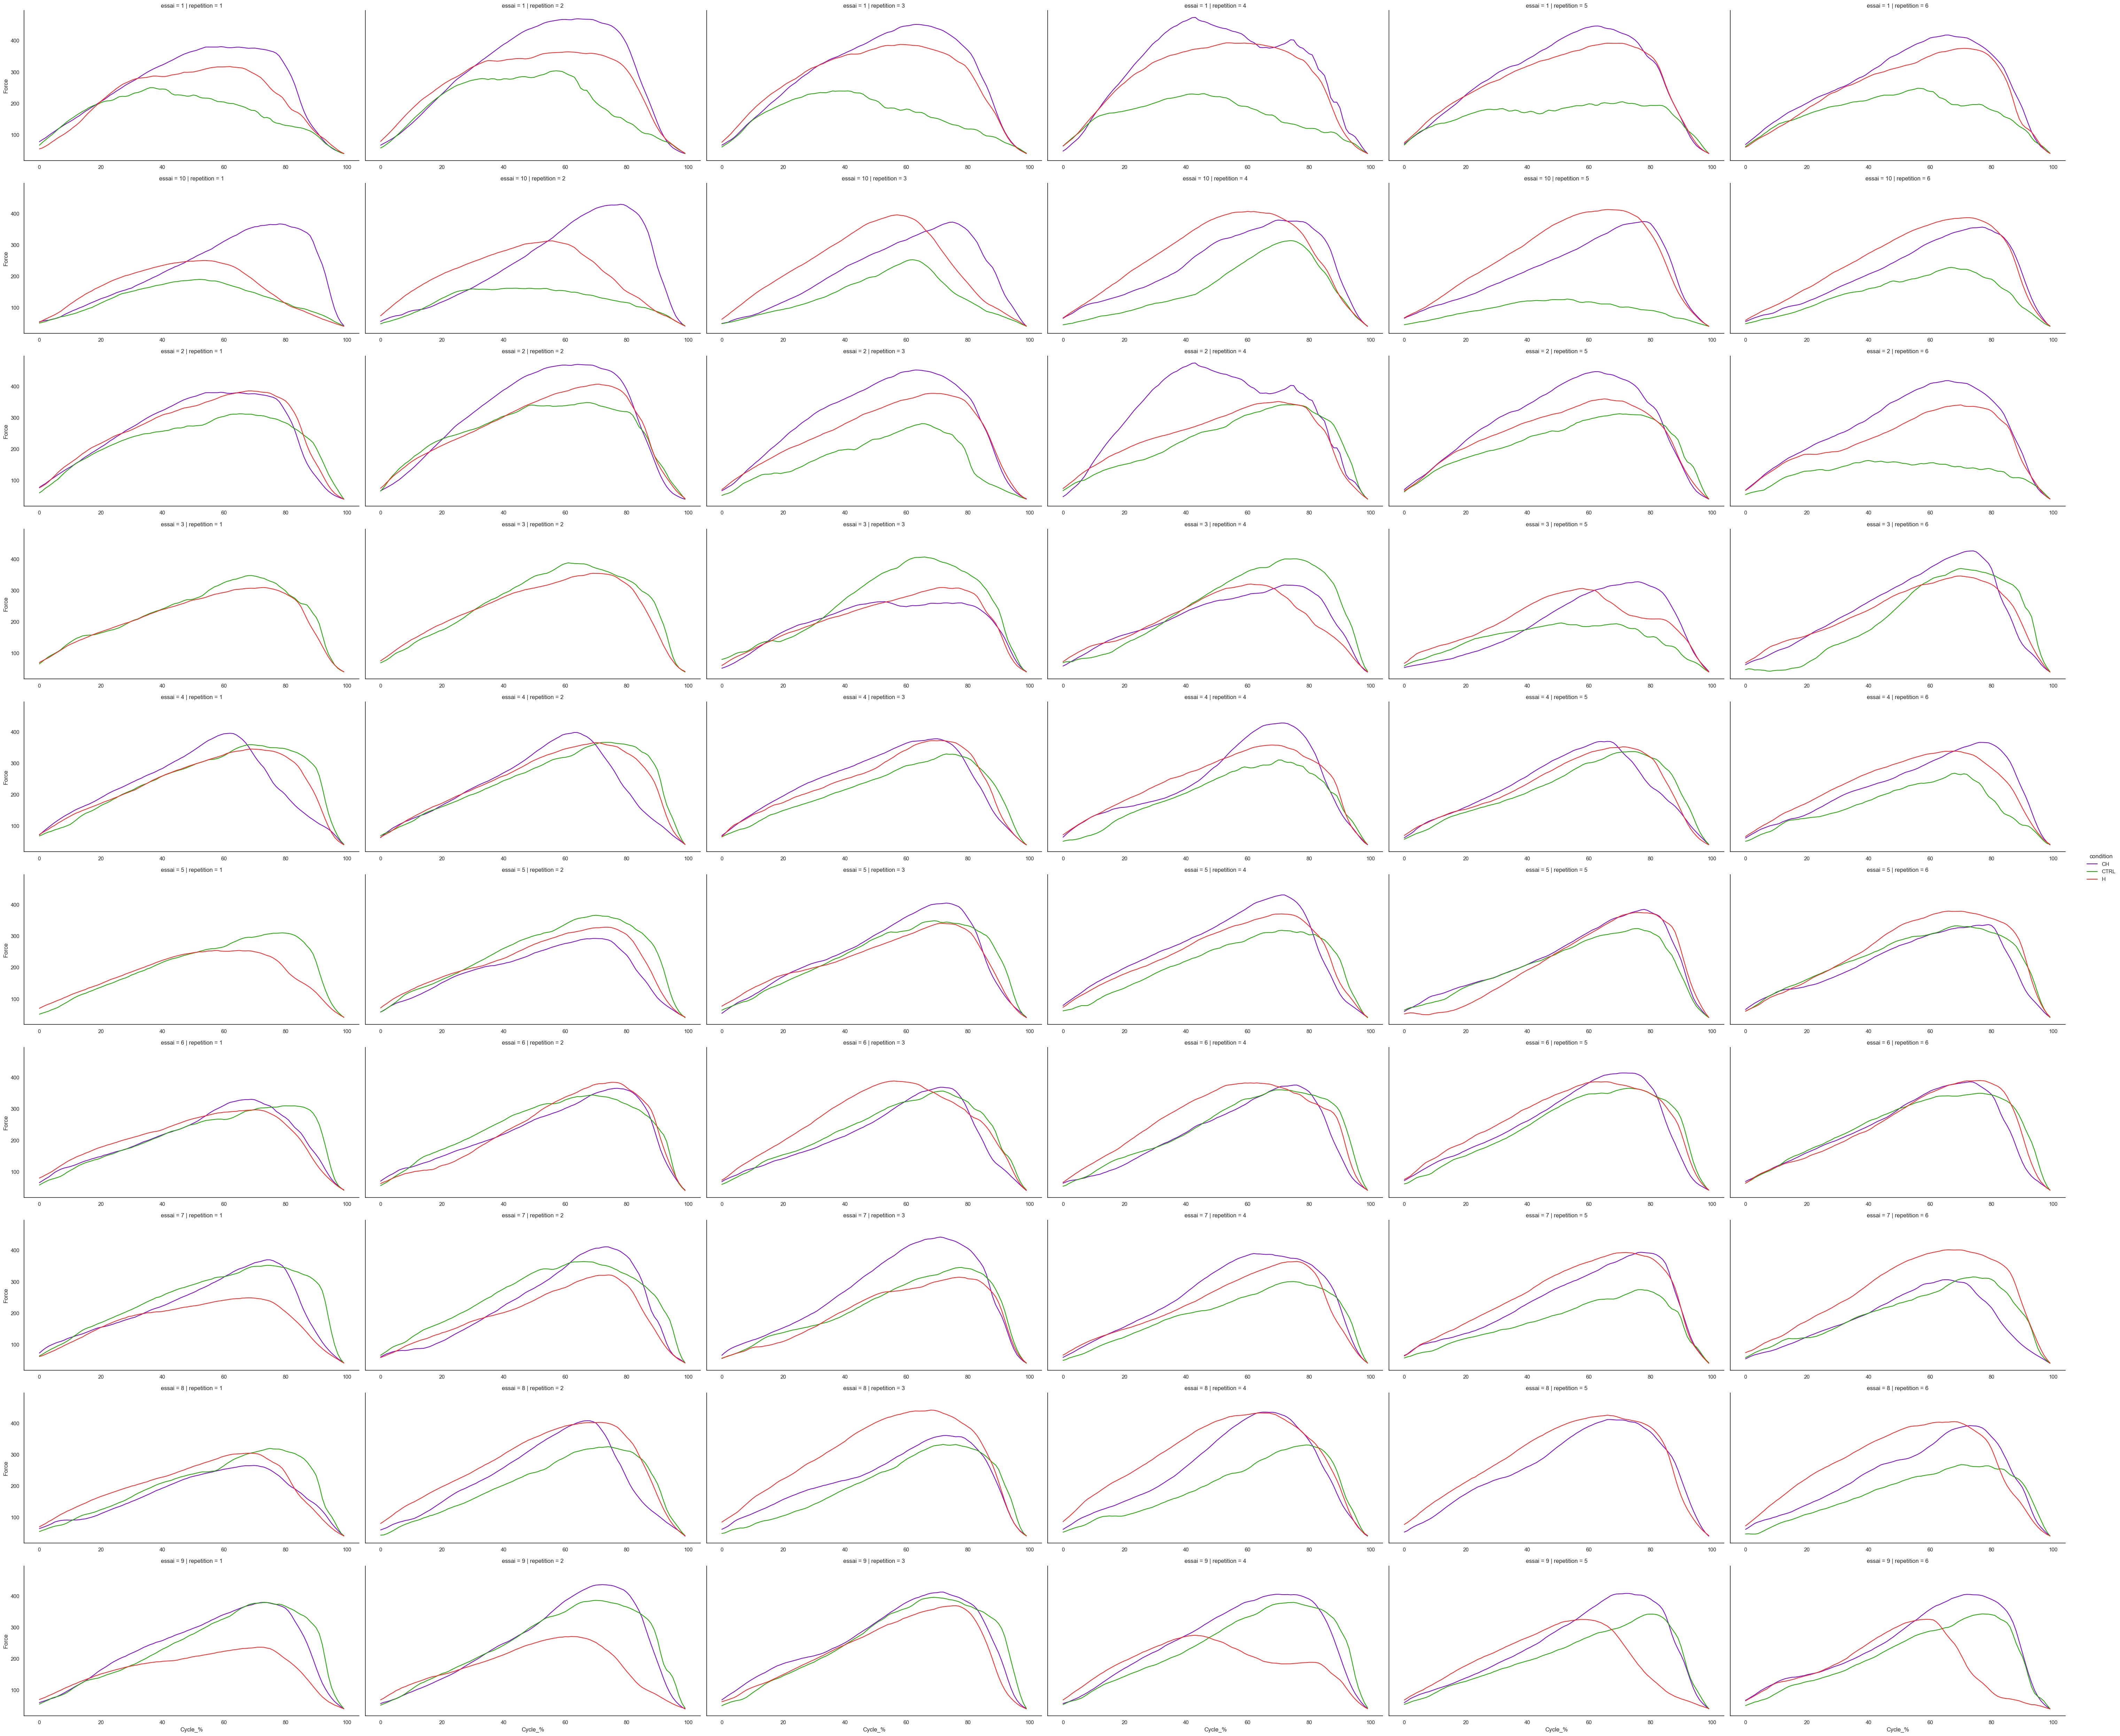

In [61]:
data_plot = df_flexion_interpol[
    (df_flexion_interpol['repetition'] != 0)
    & (df_flexion_interpol['mouvement'] == 'Extension')
    & (df_flexion_interpol['contraction'] == 'EXC')
    & (df_flexion_interpol['participant'] == '005')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
             x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
             row = 'essai',
             col = 'repetition',
             palette=palette_colors,
             facet_kws=dict(sharex=False),
             errorbar = 'sd'
             )

### Affichage de tous les participants

C:\Users\ESP Consulting\AppData\Local\Temp\ipykernel_2944\1402205466.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_plot = df_flexion_interpol[


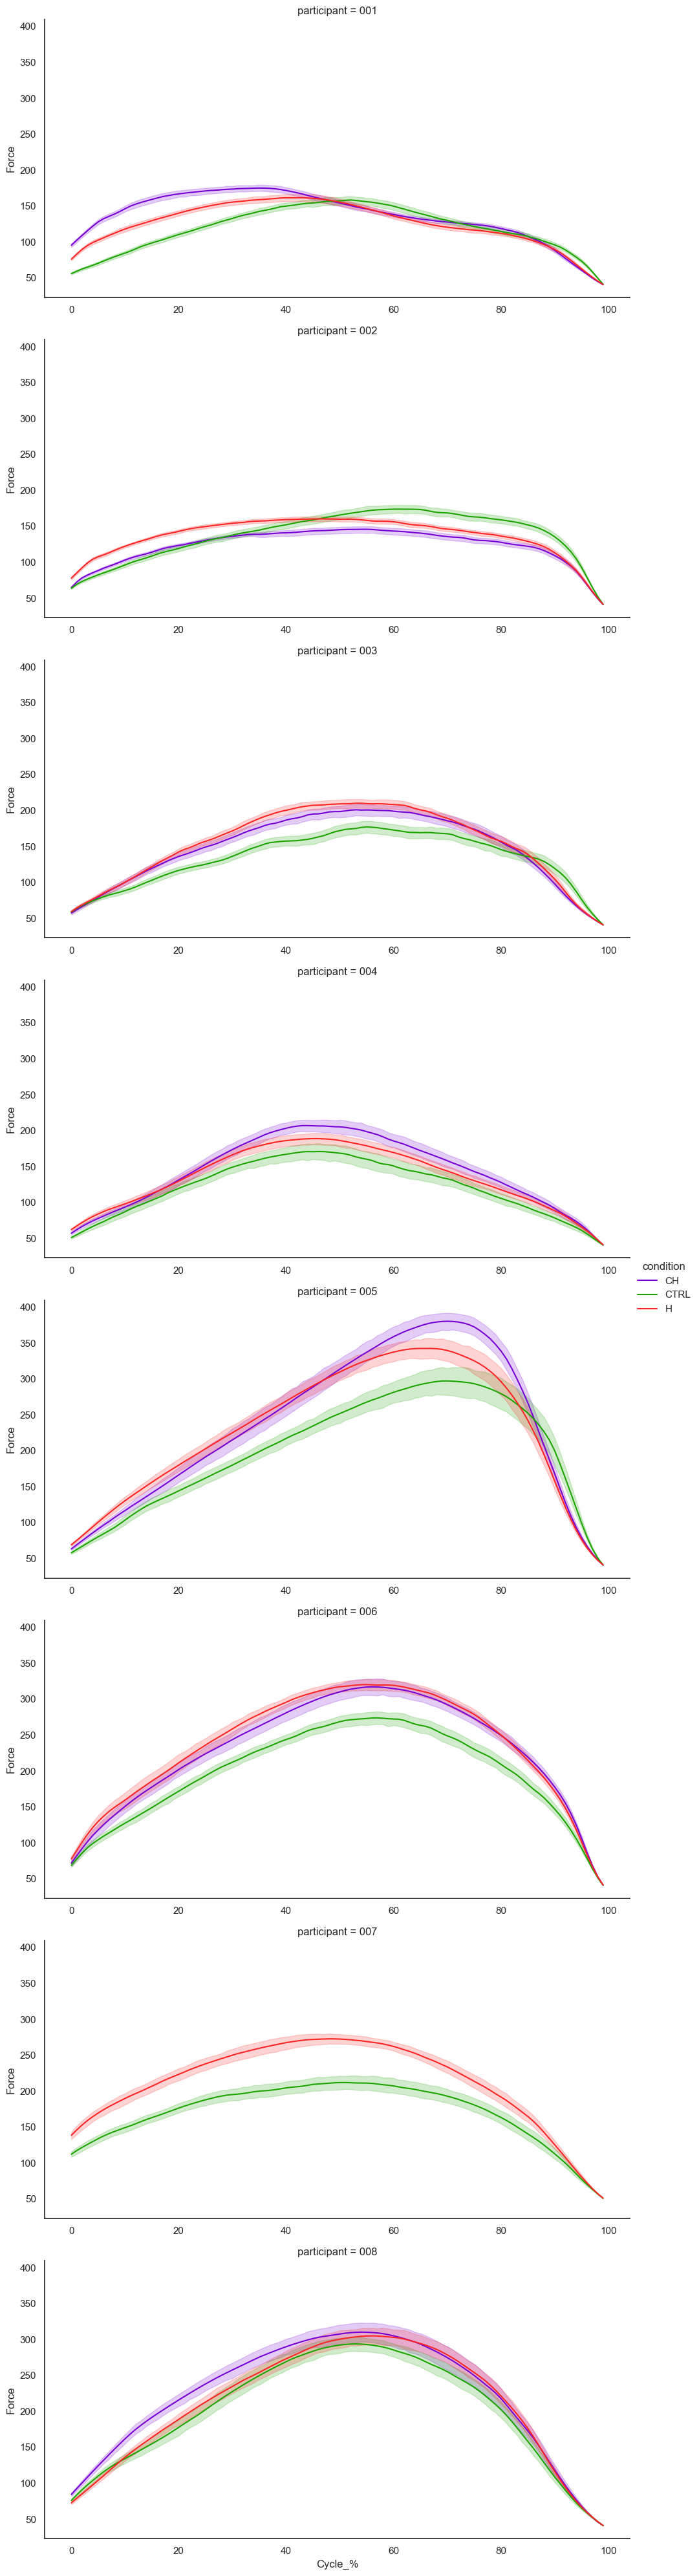

In [62]:
data_plot = df_flexion_interpol[
    (df_flexion_interpol['repetition'] != 0)
    & (df_force_phase['contraction'] == 'EXC')
    & (df_flexion_interpol['mouvement'] == 'Extension')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
            x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
             row = 'participant',
             palette=palette_colors,
             facet_kws=dict(sharex=False)
             )


# Contraction isométrique

### Affichage par participant

In [63]:
# data_plot = df_flexion_interpol[
#     (df_flexion_interpol['repetition'] != 0)
#     & (df_flexion_interpol['mouvement'] == 'Extension')
#     & (df_flexion_interpol['contraction'] == 'ISO')
#     & (df_flexion_interpol['participant'] == '005')
#     & (df_flexion_interpol['mesure'] == '11')
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#              x= 'Cycle_%',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#              row = 'essai',
#              col = 'repetition',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False),
#              errorbar = 'sd'
#              )

### Affichage de tous les participants

In [64]:
# data_plot = df_flexion_interpol[
#     (df_flexion_interpol['repetition'] != 0)
#     & (df_force_phase['contraction'] == 'ISO')
#     & (df_flexion_interpol['mouvement'] == 'Extension')
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#             x= 'Cycle_%',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#              row = 'participant',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False)
#              )